=== カスタムJavaトークナイザー版ダウンサンプリングバグ予測パイプライン ===

=== 1) データ読み込み ===
読み込み完了: 120167行, 77列

=== データ前処理（カスタムJavaトークナイザー + TF-IDF + One-Hot Encoding + 正規化使用）===
LongName TF-IDF特徴量数: 1000
Parent TF-IDF特徴量数: 1000
初期使用特徴量数 (数値 + Java TF-IDF + One-Hot Encoding): 2087
  - 数値特徴量: 72
  - LongName TF-IDF: 1000
  - Parent TF-IDF: 1000
  - Project One-Hot: 15
ラベル分布: 0=82363, 1=37804
クラス分布: 0.315 (1の割合)

=== サンプルトークン化結果 ===
LongName例: org.elasticsearch.index.fielddata.plain.GeoPointDoubleArrayAtomicFieldData$Empty.<init>()V
→ トークン: ['geo', 'point', 'array', 'atomic', 'field', 'data', 'constructor']
Parent例: org.elasticsearch.index.fielddata.plain.GeoPointDoubleArrayAtomicFieldData$Empty
→ トークン: ['geo', 'point', 'array', 'atomic', 'field', 'data']

=== ダウンサンプリング適用 ===
ダウンサンプリング前 - クラス0: 82363件, クラス1: 37804件
ダウンサンプリング後 - クラス0: 37804件, クラス1: 37804件
総データ数: 75608件 (削減率: 37.1%)
ダウンサンプリング後データセットサイズ: 75608行
訓練データ (ダウンサンプリング後): 60486行, テストデータ (ダウンサンプリング後): 15122行

=== 特徴量重要度取得のための初期モデル学習（カスタムJavaトークナイザー版）===
初期モデ

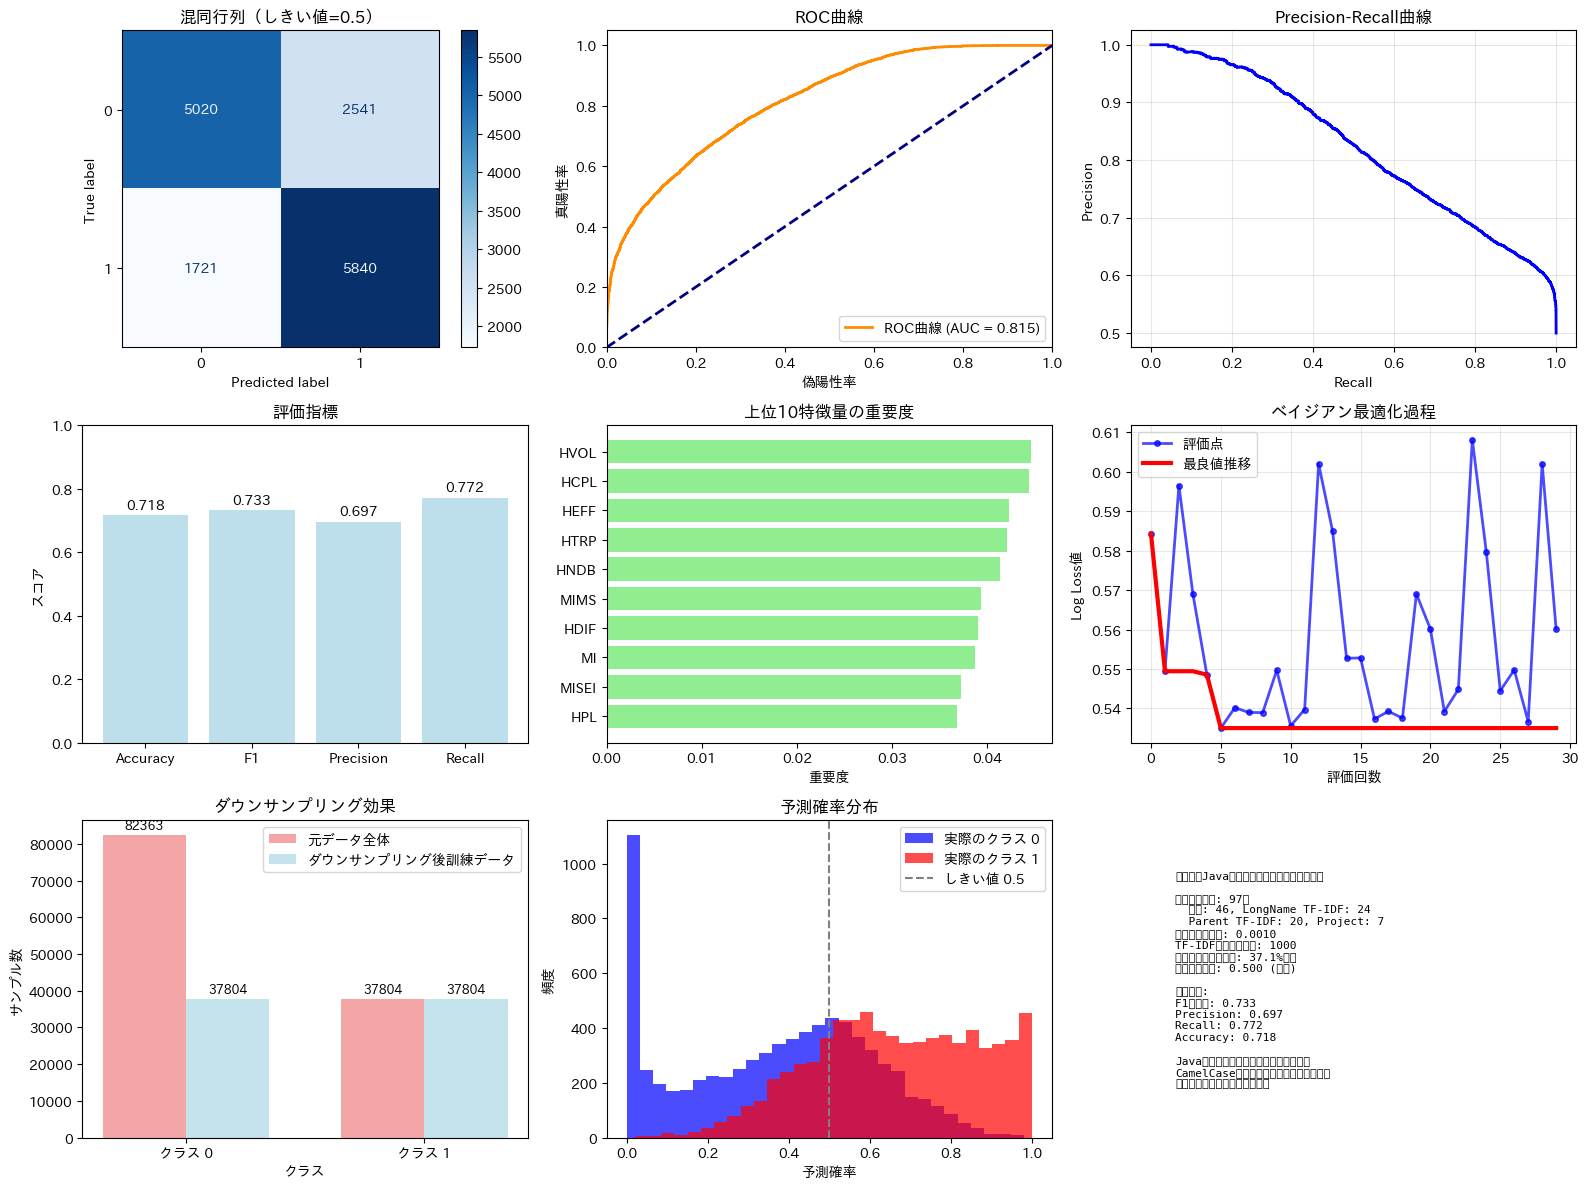


カスタムJavaトークナイザー版バグ予測完了!
F1スコア: 0.733
Precision: 0.697
Recall: 0.772
Accuracy: 0.718

=== ダウンサンプリング サマリー ===
元データ (全データ):
  クラス 0: 82,363件
  クラス 1: 37,804件
  合計: 120,167件

ダウンサンプリング後 (訓練データ):
  クラス 0: 37,804件
  クラス 1: 37,804件
  合計: 75,608件

元データ全体からの削減率: 37.1%
クラス不均衡比 (クラス0/クラス1):
  元データ (全データ): 2.18:1
  ダウンサンプリング後 (訓練データ): 1.00:1

=== 上位15特徴量重要度 (カスタムJavaトークナイザー版) ===
  特徴量 タイプ      重要度
 HVOL  数値 0.044612
 HCPL  数値 0.044425
 HEFF  数値 0.042267
 HTRP  数値 0.042127
 HNDB  数値 0.041390
 MIMS  数値 0.039358
 HDIF  数値 0.039022
   MI  数値 0.038734
MISEI  数値 0.037233
  HPL  数値 0.036824
 MISM  数値 0.036824
  HPV  数値 0.033212
  NOI  数値 0.030783
  NII  数値 0.028689
 TLOC  数値 0.024668

=== 特徴量タイプ別統計 ===
数値: 46個 (平均重要度: 0.0181)
LongName TF-IDF: 24個 (平均重要度: 0.0032)
Parent TF-IDF: 20個 (平均重要度: 0.0029)
Project: 7個 (平均重要度: 0.0043)

=== Javaトークナイザー動作例 ===
設定:
  最小トークン長: 2
  パッケージトークン含む: False
  ストップワード数: 47

=== LongName トークン化例 (上位3件) ===
1. org.elasticsearch.index.fielddata.plain.GeoPointDoubleArrayAtomicFiel

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                           roc_curve, auc, precision_recall_curve,
                           log_loss, accuracy_score, f1_score,
                           precision_score, recall_score)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample  # ダウンサンプリング用
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
import warnings
import re
from typing import List, Set
warnings.filterwarnings('ignore')

# 再現性のためのseed固定
GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)


class JavaCodeTokenizer:
    """
    Javaのメソッド名やクラス名を適切にトークン化するカスタムトークナイザー

    主な機能:
    1. パッケージ名、クラス名、メソッド名の分離
    2. CamelCaseの分割
    3. アンダースコア区切りの分割
    4. 特殊文字の処理
    5. ストップワードの除去
    """

    def __init__(self, min_token_length: int = 2, include_package_tokens: bool = True):
        """
        初期化

        Parameters:
            min_token_length (int): 最小トークン長（これより短いトークンは除外）
            include_package_tokens (bool): パッケージ名のトークンを含めるかどうか
        """
        self.min_token_length = min_token_length
        self.include_package_tokens = include_package_tokens

        # Javaでよく使われる一般的な単語（ストップワード）
        self.java_stopwords: Set[str] = {
            'java', 'util', 'lang', 'io', 'net', 'org', 'com', 'javax',
            'get', 'set', 'is', 'has', 'to', 'from', 'with', 'without',
            'init', 'new', 'create', 'build', 'make', 'do', 'run', 'execute',
            'class', 'interface', 'abstract', 'final', 'static', 'public',
            'private', 'protected', 'void', 'int', 'string', 'boolean',
            'double', 'float', 'long', 'short', 'byte', 'char',
            'impl', 'default', 'base', 'simple', 'empty'
        }

    def _split_camel_case(self, text: str) -> List[str]:
        """
        CamelCaseの文字列を単語に分割

        例: "GeoPointDoubleArray" -> ["Geo", "Point", "Double", "Array"]
        """
        # 大文字の前で分割（先頭は除く）
        parts = re.sub(r'(?<!^)(?=[A-Z])', ' ', text).split()
        return [part for part in parts if len(part) >= self.min_token_length]

    def _split_snake_case(self, text: str) -> List[str]:
        """
        snake_caseやkebab-caseの文字列を単語に分割

        例: "atomic_field_data" -> ["atomic", "field", "data"]
        """
        parts = re.split(r'[_\-]', text)
        return [part for part in parts if len(part) >= self.min_token_length]

    def _extract_method_signature_tokens(self, method_signature: str) -> List[str]:
        """
        メソッドシグネチャからトークンを抽出

        例: "org.elasticsearch.index.fielddata.plain.GeoPointDoubleArrayAtomicFieldData$Empty.<init>()V"
        """
        tokens = []

        # メソッドシグネチャのパターンマッチング
        # パッケージ.クラス名.メソッド名(引数)戻り値型 の形式
        pattern = r'^(.*?)\.([^.()]+)\(([^)]*)\)(.*)$'
        match = re.match(pattern, method_signature)

        if match:
            package_and_class = match.group(1)  # パッケージ+クラス部分
            method_name = match.group(2)        # メソッド名
            parameters = match.group(3)         # 引数部分
            return_type = match.group(4)        # 戻り値型

            # パッケージとクラス名の処理
            if package_and_class:
                package_parts = package_and_class.split('.')

                # パッケージ名の処理（オプション）
                if self.include_package_tokens:
                    for part in package_parts[:-1]:  # 最後はクラス名なので除外
                        if part and len(part) >= self.min_token_length:
                            tokens.append(part.lower())

                # クラス名の処理（最後の部分）
                if package_parts:
                    class_name = package_parts[-1]
                    # 内部クラス記号 $ の処理
                    class_parts = class_name.split('$')
                    for class_part in class_parts:
                        if class_part:
                            # CamelCaseの分割
                            camel_tokens = self._split_camel_case(class_part)
                            tokens.extend([token.lower() for token in camel_tokens])

            # メソッド名の処理
            if method_name and method_name != '<init>' and method_name != '<clinit>':
                # アンダースコアで分割
                snake_tokens = self._split_snake_case(method_name)
                for token in snake_tokens:
                    # CamelCaseの分割
                    camel_tokens = self._split_camel_case(token)
                    tokens.extend([token.lower() for token in camel_tokens])
            elif method_name in ['<init>', '<clinit>']:
                tokens.append('constructor')

        else:
            # パターンにマッチしない場合は単純に分割
            # ドット区切りで分割
            parts = method_signature.split('.')
            for part in parts:
                if part and '(' not in part:  # 引数部分を除外
                    # CamelCaseとsnake_caseの両方で分割
                    snake_tokens = self._split_snake_case(part)
                    for token in snake_tokens:
                        camel_tokens = self._split_camel_case(token)
                        tokens.extend([token.lower() for token in camel_tokens])

        return tokens

    def _extract_class_name_tokens(self, class_name: str) -> List[str]:
        """
        クラス名からトークンを抽出

        例: "org.elasticsearch.index.fielddata.plain.GeoPointDoubleArrayAtomicFieldData$Empty"
        """
        tokens = []

        # パッケージとクラス名を分離
        parts = class_name.split('.')

        # パッケージ名の処理（オプション）
        if self.include_package_tokens:
            for part in parts[:-1]:  # 最後はクラス名なので除外
                if part and len(part) >= self.min_token_length:
                    tokens.append(part.lower())

        # クラス名の処理（最後の部分）
        if parts:
            class_part = parts[-1]
            # 内部クラス記号 $ の処理
            class_components = class_part.split('$')
            for component in class_components:
                if component:
                    # CamelCaseの分割
                    camel_tokens = self._split_camel_case(component)
                    tokens.extend([token.lower() for token in camel_tokens])

        return tokens

    def tokenize_longname(self, longname: str) -> List[str]:
        """
        LongName列の値をトークン化（メソッドシグネチャ）
        """
        if not longname or pd.isna(longname):
            return []

        tokens = self._extract_method_signature_tokens(str(longname))

        # ストップワードの除去と最小長チェック
        filtered_tokens = [
            token for token in tokens
            if len(token) >= self.min_token_length and token.lower() not in self.java_stopwords
        ]

        return filtered_tokens

    def tokenize_parent(self, parent: str) -> List[str]:
        """
        Parent列の値をトークン化（クラス名）
        """
        if not parent or pd.isna(parent):
            return []

        tokens = self._extract_class_name_tokens(str(parent))

        # ストップワードの除去と最小長チェック
        filtered_tokens = [
            token for token in tokens
            if len(token) >= self.min_token_length and token.lower() not in self.java_stopwords
        ]

        return filtered_tokens

    def __call__(self, text: str) -> List[str]:
        """
        TfidfVectorizerのtokenizer引数で使用するためのメソッド
        LongNameとParentの両方に対応する汎用的なトークン化
        """
        if not text or pd.isna(text):
            return []

        text_str = str(text)

        # メソッドシグネチャかクラス名かを判定
        if '(' in text_str and ')' in text_str:
            # メソッドシグネチャとして処理
            return self.tokenize_longname(text_str)
        else:
            # クラス名として処理
            return self.tokenize_parent(text_str)


class SimplifiedBugHunter:
    """
    カスタムJavaトークナイザー統合版ダウンサンプリング版バグ予測クラス

    主な変更点:
    - JavaCodeTokenizerを使用したTF-IDF特徴量抽出
    - LongNameとParentカラムのJava固有の構造を考慮したトークン化
    - CamelCase、snake_case、パッケージ構造の適切な処理
    """

    def __init__(self, feature_selection_threshold: float = 0.001,
                 tfidf_max_features: int = 1000,
                 java_tokenizer_min_length: int = 2,
                 include_package_tokens: bool = False):
        """
        コンストラクタ

        Parameters:
            feature_selection_threshold (float): 特徴量重要度の閾値
            tfidf_max_features (int): TF-IDFで生成する特徴量の最大数
            java_tokenizer_min_length (int): Javaトークナイザーの最小トークン長
            include_package_tokens (bool): パッケージ名のトークンを含めるかどうか
        """
        self.best_model = None
        self.feature_importance = None
        self.all_feature_names = None
        self.selected_features = None
        self.optimization_history = []
        self.best_params = None
        self.best_loss = float('inf')
        self.feature_selection_threshold = feature_selection_threshold
        self.initial_X = None
        self.initial_y = None
        self.tfidf_vectorizer_longname = None
        self.tfidf_vectorizer_parent = None
        self.tfidf_max_features = tfidf_max_features
        self.project_dummies_columns = None
        self.scaler = None

        # Javaトークナイザーの初期化
        self.java_tokenizer = JavaCodeTokenizer(
            min_token_length=java_tokenizer_min_length,
            include_package_tokens=include_package_tokens
        )

        # ダウンサンプリング関連の属性
        self.downsampled_X = None
        self.downsampled_y = None
        self.original_class_distribution = None
        self.downsampled_train_distribution = None

    def read_data(self, data_path: str) -> pd.DataFrame:
        """データ読み込み"""
        print("\n=== 1) データ読み込み ===")
        df = pd.read_csv(data_path)
        print(f"読み込み完了: {len(df)}行, {len(df.columns)}列")
        return df

    def prepare_data(self, data: pd.DataFrame, is_training: bool = True) -> tuple:
        """データの前処理とラベル作成（カスタムJavaトークナイザー使用）"""
        print("\n=== データ前処理（カスタムJavaトークナイザー + TF-IDF + One-Hot Encoding + 正規化使用）===")

        # ラベル作成（Number of Bugs > 0.5で1、それ以外で0）
        y = (data["Number of Bugs"] > 0.5).astype(int) if "Number of Bugs" in data.columns and is_training else None

        # 元の数値特徴量を選択（Number of Bugsを除く）
        numerical_feature_columns = data.select_dtypes(include=[np.number]).columns.tolist()
        numerical_feature_columns = [col for col in numerical_feature_columns if col != "Number of Bugs"]
        X_numerical = data[numerical_feature_columns].copy()

        # 欠損値・無限値の処理 (数値特徴量)
        X_numerical = X_numerical.replace([np.inf, -np.inf], np.nan)
        X_numerical = X_numerical.fillna(0)

        # 正規化処理
        if is_training:
            self.scaler = StandardScaler()
            X_numerical_scaled = self.scaler.fit_transform(X_numerical)
        else:
            if self.scaler is None:
                raise ValueError("Scalerが学習されていません。まず訓練データでprepare_dataを実行してください。")
            X_numerical_scaled = self.scaler.transform(X_numerical)
        X_numerical_scaled_df = pd.DataFrame(X_numerical_scaled, columns=numerical_feature_columns, index=X_numerical.index)

        # LongNameカラムにカスタムJavaトークナイザーを使用したTF-IDFを適用
        longname_data = data['LongName'].fillna("").astype(str)
        if is_training:
            self.tfidf_vectorizer_longname = TfidfVectorizer(
                max_features=self.tfidf_max_features,
                tokenizer=self.java_tokenizer,
                lowercase=False,  # トークナイザー内で小文字化を行うため
                token_pattern=None  # カスタムトークナイザーを使用するため
            )
            X_longname_tfidf = self.tfidf_vectorizer_longname.fit_transform(longname_data)
            print(f"LongName TF-IDF特徴量数: {X_longname_tfidf.shape[1]}")
        else:
            if self.tfidf_vectorizer_longname is None:
                raise ValueError("TF-IDF vectorizer (LongName)が学習されていません。まず訓練データでprepare_dataを実行してください。")
            X_longname_tfidf = self.tfidf_vectorizer_longname.transform(longname_data)
        X_longname_tfidf_df = pd.DataFrame(X_longname_tfidf.toarray(),
                                            columns=[f'LongName_tfidf_{i}' for i in range(X_longname_tfidf.shape[1])],
                                            index=longname_data.index)

        # ParentカラムにカスタムJavaトークナイザーを使用したTF-IDFを適用
        parent_data = data['Parent'].fillna("").astype(str)
        if is_training:
            self.tfidf_vectorizer_parent = TfidfVectorizer(
                max_features=self.tfidf_max_features,
                tokenizer=self.java_tokenizer,
                lowercase=False,  # トークナイザー内で小文字化を行うため
                token_pattern=None  # カスタムトークナイザーを使用するため
            )
            X_parent_tfidf = self.tfidf_vectorizer_parent.fit_transform(parent_data)
            print(f"Parent TF-IDF特徴量数: {X_parent_tfidf.shape[1]}")
        else:
            if self.tfidf_vectorizer_parent is None:
                raise ValueError("TF-IDF vectorizer (Parent)が学習されていません。まず訓練データでprepare_dataを実行してください。")
            X_parent_tfidf = self.tfidf_vectorizer_parent.transform(parent_data)
        X_parent_tfidf_df = pd.DataFrame(X_parent_tfidf.toarray(),
                                          columns=[f'Parent_tfidf_{i}' for i in range(X_parent_tfidf.shape[1])],
                                          index=parent_data.index)

        # ProjectカラムにOne-Hot Encodingを適用
        project_data = data['Project'].fillna("Unknown").astype(str)
        X_project_onehot = pd.get_dummies(project_data, prefix='Project', dtype=int)
        if is_training:
            self.project_dummies_columns = X_project_onehot.columns.tolist()
        else:
            if self.project_dummies_columns is None:
                raise ValueError("One-Hot Encodingのカラム情報が学習されていません。まず訓練データでprepare_dataを実行してください。")
            X_project_onehot = X_project_onehot.reindex(columns=self.project_dummies_columns, fill_value=0)

        # 全てのXを結合
        X = pd.concat([X_numerical_scaled_df, X_longname_tfidf_df, X_parent_tfidf_df, X_project_onehot], axis=1)

        if is_training:
            self.all_feature_names = X.columns.tolist()
            self.initial_X = X
            self.initial_y = y

            print(f"初期使用特徴量数 (数値 + Java TF-IDF + One-Hot Encoding): {len(X.columns)}")
            print(f"  - 数値特徴量: {len(numerical_feature_columns)}")
            print(f"  - LongName TF-IDF: {X_longname_tfidf.shape[1]}")
            print(f"  - Parent TF-IDF: {X_parent_tfidf.shape[1]}")
            print(f"  - Project One-Hot: {len(X_project_onehot.columns)}")
            print(f"ラベル分布: 0={sum(y==0)}, 1={sum(y==1)}")

            # クラス分布の情報を保存
            self.original_class_distribution = {
                'class_0': sum(y==0),
                'class_1': sum(y==1),
                'total': len(y)
            }
            class_ratio = sum(y==1) / len(y)
            print(f"クラス分布: {class_ratio:.3f} (1の割合)")

            # サンプルトークン化結果の表示
            print("\n=== サンプルトークン化結果 ===")
            sample_longname = longname_data.iloc[0] if len(longname_data) > 0 else ""
            sample_parent = parent_data.iloc[0] if len(parent_data) > 0 else ""

            if sample_longname:
                sample_tokens_longname = self.java_tokenizer(sample_longname)
                print(f"LongName例: {sample_longname}")
                print(f"→ トークン: {sample_tokens_longname}")

            if sample_parent:
                sample_tokens_parent = self.java_tokenizer(sample_parent)
                print(f"Parent例: {sample_parent}")
                print(f"→ トークン: {sample_tokens_parent}")
        else:
            print(f"予測データの前処理完了: {len(X.columns)}列")

        return X, y

    def apply_downsampling(self, X: pd.DataFrame, y: pd.Series) -> tuple:
        """
        ダウンサンプリングを適用してクラス不均衡を解決

        Parameters:
            X (pd.DataFrame): 特徴量データ
            y (pd.Series): ラベルデータ

        Returns:
            tuple: ダウンサンプリング後の(X, y)
        """
        print("\n=== ダウンサンプリング適用 ===")

        # 各クラスのデータを分離
        X_class_0 = X[y == 0]
        X_class_1 = X[y == 1]
        y_class_0 = y[y == 0]
        y_class_1 = y[y == 1]

        print(f"ダウンサンプリング前 - クラス0: {len(X_class_0)}件, クラス1: {len(X_class_1)}件")

        # 少数派クラス（クラス1）の数に合わせて多数派クラス（クラス0）をダウンサンプリング
        minority_class_size = len(X_class_1)

        if len(X_class_0) > minority_class_size:
            # ダウンサンプリングを実行
            X_class_0_downsampled, y_class_0_downsampled = resample(
                X_class_0, y_class_0,
                n_samples=minority_class_size,
                random_state=GLOBAL_SEED,
                replace=False
            )

            # ダウンサンプリング後のデータを結合
            X_balanced = pd.concat([X_class_0_downsampled, X_class_1], axis=0)
            y_balanced = pd.concat([y_class_0_downsampled, y_class_1], axis=0)

            # インデックスをリセット
            X_balanced = X_balanced.reset_index(drop=True)
            y_balanced = y_balanced.reset_index(drop=True)

            # ランダムにシャッフル
            shuffle_indices = np.random.RandomState(GLOBAL_SEED).permutation(len(X_balanced))
            X_balanced = X_balanced.iloc[shuffle_indices].reset_index(drop=True)
            y_balanced = y_balanced.iloc[shuffle_indices].reset_index(drop=True)

            print(f"ダウンサンプリング後 - クラス0: {len(X_class_0_downsampled)}件, クラス1: {len(X_class_1)}件")
            print(f"総データ数: {len(X_balanced)}件 (削減率: {(1 - len(X_balanced) / len(X)) * 100:.1f}%)")

        else:
            # ダウンサンプリングが不要な場合
            X_balanced = X.copy()
            y_balanced = y.copy()
            print("ダウンサンプリング不要: クラス1の方が多いか、同数です")

        # ダウンサンプリング後の訓練データのクラス分布を保存
        self.downsampled_train_distribution = {
            'class_0': sum(y_balanced == 0),
            'class_1': sum(y_balanced == 1),
            'total': len(y_balanced)
        }

        return X_balanced, y_balanced

    def log_loss_function(self, y_true: np.ndarray, y_pred_proba: np.ndarray) -> float:
        """Log Loss損失関数"""
        y_pred_proba_clipped = np.clip(y_pred_proba, 1e-15, 1 - 1e-15)
        return log_loss(y_true, y_pred_proba_clipped)

    def evaluate_model_with_cv(self, params: dict, X: pd.DataFrame, y: pd.Series,
                              k_folds: int = 3) -> float:
        """交差検証を用いたモデル評価（ダウンサンプリングは外部で適用済み）"""
        try:
            # Random Forestモデルの作成（class_weightは削除）
            rf = RandomForestClassifier(
                n_estimators=int(params['n_estimators']),
                max_depth=int(params['max_depth']),
                random_state=GLOBAL_SEED,
                n_jobs=-1
            )

            # 交差検証でLog Lossを評価
            cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=GLOBAL_SEED)
            total_loss = 0.0

            for train_idx, val_idx in cv.split(X, y):
                X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
                y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

                # 各フォールド内でダウンサンプリングは行わない（すでに外で適用済み）
                # ここではX_train_fold, y_train_fold をそのまま使用
                rf.fit(X_train_fold, y_train_fold)

                # 予測確率取得
                y_pred_proba = rf.predict_proba(X_val_fold)[:, 1]

                # Log Loss計算
                fold_loss = self.log_loss_function(y_val_fold, y_pred_proba)
                total_loss += fold_loss

            avg_loss = total_loss / k_folds
            return avg_loss

        except Exception as e:
            print(f"評価エラー: {e}")
            return float('inf')

    def optimize_hyperparameters_with_log_loss(self, X: pd.DataFrame, y: pd.Series,
                                                max_iterations: int = 30) -> dict:
        """Log Loss損失関数を用いたベイジアン最適化（ダウンサンプリングは外部で適用済み）"""
        print("\n=== Log Lossベース ベイジアン最適化（カスタムJavaトークナイザー使用）===")
        print("最適化手法: Bayesian Optimization (scikit-optimize)")
        print("探索パラメータ: n_estimators, max_depth")
        print("クラス不均衡対応: ダウンサンプリング (事前に適用済み)")
        print("特徴量: 数値 + Java TF-IDF + One-Hot Encoding + 正規化")

        self.best_loss = float('inf')
        self.best_params = None
        self.optimization_history = []

        # 探索空間の定義
        search_space = [
            Integer(100, 500, name='n_estimators'),
            Integer(10, 30, name='max_depth'),
        ]

        # 目的関数
        def objective(params):
            n_estimators, max_depth = params

            param_dict = {
                'n_estimators': int(n_estimators),
                'max_depth': int(max_depth),
            }

            # モデル評価 (X, y はすでにダウンサンプリング済み)
            loss = self.evaluate_model_with_cv(param_dict, X, y)

            # 履歴記録
            self.optimization_history.append({
                'params': param_dict.copy(),
                'loss': loss
            })

            # 最良パラメータ更新
            if loss < self.best_loss:
                self.best_loss = loss
                self.best_params = param_dict.copy()
                print(f"新しい最良損失: {loss:.4f}")
                print(f"パラメータ: {param_dict}")

            return loss

        # Bayesian Optimization実行
        print("Bayesian Optimization開始...")
        result = gp_minimize(
            func=objective,
            dimensions=search_space,
            n_calls=max_iterations,
            random_state=GLOBAL_SEED,
            acq_func='EI',
            n_initial_points=5
        )

        print(f"\nBayesian Optimization完了!")
        print(f"最良損失: {self.best_loss:.4f}")
        final_best_params = self.best_params.copy() if self.best_params else {}
        print(f"最良パラメータ: {final_best_params}")
        print(f"総評価回数: {len(self.optimization_history)}")

        return final_best_params

    def train_initial_model_for_feature_importance(self, X: pd.DataFrame, y: pd.Series):
        """特徴量重要度を取得するための初期モデルを学習（ダウンサンプリング済みデータで学習）"""
        print("\n=== 特徴量重要度取得のための初期モデル学習（カスタムJavaトークナイザー版）===")

        # X, y はすでにダウンサンプリング済みとして受け取る
        initial_rf = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=GLOBAL_SEED,
            n_jobs=-1
        )
        initial_rf.fit(X, y)
        self.feature_importance = initial_rf.feature_importances_
        print("初期モデル学習と特徴量重要度の計算が完了しました。")
        return initial_rf

    def select_features_by_importance(self, X: pd.DataFrame) -> pd.DataFrame:
        """特徴量重要度に基づいて特徴量を選択"""
        if self.feature_importance is None:
            raise ValueError("特徴量重要度が計算されていません。まず初期モデルを学習してください。")

        feature_names = self.all_feature_names
        if len(feature_names) != len(self.feature_importance):
            print("警告: 特徴量名と重要度の数が一致しません。現在のXのカラムを再確認します。")
            feature_names = X.columns.tolist()
            if len(feature_names) != len(self.feature_importance):
                raise ValueError("特徴量名と重要度の数が一致しません。")

        # 重要度が閾値以上の特徴量を選択
        selected_feature_indices = np.where(self.feature_importance >= self.feature_selection_threshold)[0]
        self.selected_features = [feature_names[i] for i in selected_feature_indices]

        # 選択された特徴量が存在しない場合のエラーハンドリング
        if not self.selected_features:
            print(f"警告: 特徴量重要度の閾値 {self.feature_selection_threshold} では、どの特徴量も選択されませんでした。")
            print("すべての特徴量を再度含めて処理を続行します。")
            self.selected_features = feature_names
            X_selected = X
        else:
            X_selected = X[self.selected_features]

        print(f"\n=== 特徴量削減 ===")
        print(f"特徴量削減前の数: {len(feature_names)}")
        print(f"選択された特徴量数 (閾値 {self.feature_selection_threshold}): {len(self.selected_features)}")

        # 特徴量タイプ別の統計
        longname_count = len([f for f in self.selected_features if f.startswith('LongName_tfidf_')])
        parent_count = len([f for f in self.selected_features if f.startswith('Parent_tfidf_')])
        project_count = len([f for f in self.selected_features if f.startswith('Project_')])
        numerical_count = len(self.selected_features) - longname_count - parent_count - project_count

        print(f"  - 数値特徴量: {numerical_count}")
        print(f"  - LongName TF-IDF: {longname_count}")
        print(f"  - Parent TF-IDF: {parent_count}")
        print(f"  - Project One-Hot: {project_count}")

        return X_selected

    def train_optimized_model(self, X: pd.DataFrame, y: pd.Series, optimal_params: dict):
        """最適化されたパラメータでモデルを学習（ダウンサンプリング済みデータで学習）"""
        print("\n=== 最適化モデル学習（カスタムJavaトークナイザー版）===")

        # X, y はすでにダウンサンプリング済みとして受け取る
        rf_params = {
            'n_estimators': int(optimal_params['n_estimators']),
            'max_depth': int(optimal_params['max_depth']),
            'random_state': GLOBAL_SEED,
            'n_jobs': -1
        }

        self.best_model = RandomForestClassifier(**rf_params)
        self.best_model.fit(X, y)

        print("最適化モデル学習完了")
        print(f"最終パラメータ: {rf_params}")
        print(f"学習データ: {len(X)}件")

        # 特徴量重要度の取得
        if hasattr(self.best_model, 'feature_importances_'):
            self.feature_importance = self.best_model.feature_importances_
            print("学習済みモデルから特徴量重要度を計算しました。")
        else:
            self.feature_importance = None
            print("警告: 学習済みモデルは特徴量重要度を提供しません。")

        return self.best_model

    def comprehensive_evaluation(self, X_test: pd.DataFrame, y_test: pd.Series) -> dict:
        """包括的評価（デフォルトしきい値0.5のみ使用）"""
        print("\n=== 包括的評価 ===")

        # 予測確率取得
        y_pred_proba = self.best_model.predict_proba(X_test)[:, 1]

        # デフォルトしきい値（0.5）での予測
        y_pred = (y_pred_proba >= 0.5).astype(int)

        # 評価指標の計算
        results = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred, zero_division=0),
            'Precision': precision_score(y_test, y_pred, zero_division=0),
            'Recall': recall_score(y_test, y_pred),
            'LogLoss': self.log_loss_function(y_test, y_pred_proba),
            'Threshold': 0.5
        }

        print("\n--- 評価結果（しきい値=0.5）---")
        for metric, score in results.items():
            if metric != 'Threshold':
                print(f"{metric}: {score:.4f}")

        return results, y_pred, y_pred_proba

    def plot_results(self, results: dict, y_test: pd.Series, y_pred: np.ndarray,
                    y_pred_proba: np.ndarray, X_test: pd.DataFrame):
        """結果の可視化（カスタムJavaトークナイザー版）"""
        print("\n=== 結果可視化 ===")

        plt.figure(figsize=(16, 12))

        # 1. 混同行列
        plt.subplot(3, 3, 1)
        conf_matrix = confusion_matrix(y_test, y_pred)
        display_matrix = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                              display_labels=[0, 1])
        display_matrix.plot(ax=plt.gca(), cmap='Blues')
        plt.title(f"混同行列（しきい値=0.5）")

        # 2. ROC曲線
        plt.subplot(3, 3, 2)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC曲線 (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('偽陽性率')
        plt.ylabel('真陽性率')
        plt.title('ROC曲線')
        plt.legend(loc="lower right")

        # 3. Precision-Recall曲線
        plt.subplot(3, 3, 3)
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        plt.plot(recall, precision, color='blue', lw=2)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall曲線')
        plt.grid(True, alpha=0.3)

        # 4. 評価指標表示
        plt.subplot(3, 3, 4)
        metrics = ['Accuracy', 'F1', 'Precision', 'Recall']
        values = [results.get(metric, 0) for metric in metrics]

        bars = plt.bar(metrics, values, color='lightblue', alpha=0.8)
        plt.title('評価指標')
        plt.ylabel('スコア')
        plt.ylim(0, 1)

        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=10)

        # 5. 特徴量重要度（上位10個）
        plt.subplot(3, 3, 5)
        if self.feature_importance is not None and len(self.feature_importance) > 0 and self.selected_features is not None:
            feature_names = self.selected_features
            if len(self.feature_importance) == len(feature_names):
                top_indices = self.feature_importance.argsort()[-10:][::-1]
                top_features = [feature_names[i] for i in top_indices]

                # 特徴量名を短縮して表示
                short_features = []
                for feat in top_features:
                    if len(feat) > 20:
                        short_features.append(feat[:17] + '...')
                    else:
                        short_features.append(feat)

                plt.barh(range(len(top_indices)),
                        self.feature_importance[top_indices],
                        color='lightgreen')
                plt.yticks(range(len(top_indices)), short_features)
                plt.xlabel('重要度')
                plt.title('上位10特徴量の重要度')
                plt.gca().invert_yaxis()
            else:
                plt.text(0.5, 0.5, '特徴量名と重要度の不一致',
                         horizontalalignment='center', verticalalignment='center',
                         transform=plt.gca().transAxes, fontsize=12, color='gray')
                plt.title('特徴量重要度')
                plt.axis('off')
        else:
            plt.text(0.5, 0.5, '特徴量重要度は利用できません',
                     horizontalalignment='center', verticalalignment='center',
                     transform=plt.gca().transAxes, fontsize=12, color='gray')
            plt.title('特徴量重要度')
            plt.axis('off')

        # 6. ベイジアン最適化履歴
        plt.subplot(3, 3, 6)
        if self.optimization_history:
            losses = [entry['loss'] for entry in self.optimization_history]
            iterations = range(len(losses))

            plt.plot(iterations, losses, 'bo-', linewidth=2, markersize=4,
                    alpha=0.7, label='評価点')

            # 最良値の推移
            cumulative_best = []
            current_best = float('inf')
            for loss in losses:
                if loss < current_best:
                    current_best = loss
                cumulative_best.append(current_best)

            plt.plot(iterations, cumulative_best, 'r-', linewidth=3,
                    label='最良値推移')

            plt.xlabel('評価回数')
            plt.ylabel('Log Loss値')
            plt.title('ベイジアン最適化過程')
            plt.grid(True, alpha=0.3)
            plt.legend()

        # 7. ダウンサンプリング効果の可視化
        plt.subplot(3, 3, 7)
        if self.original_class_distribution and self.downsampled_train_distribution:
            # 元のクラス分布（データ全体）
            original_counts_total = [self.original_class_distribution['class_0'],
                                     self.original_class_distribution['class_1']]
            # ダウンサンプリング後の訓練データのクラス分布
            downsampled_counts_train = [self.downsampled_train_distribution['class_0'],
                                        self.downsampled_train_distribution['class_1']]

            x = np.arange(2)
            width = 0.35

            plt.bar(x - width/2, original_counts_total, width, label='元データ全体', alpha=0.7, color='lightcoral')
            plt.bar(x + width/2, downsampled_counts_train, width, label='ダウンサンプリング後訓練データ', alpha=0.7, color='lightblue')

            plt.xlabel('クラス')
            plt.ylabel('サンプル数')
            plt.title('ダウンサンプリング効果')
            plt.xticks(x, ['クラス 0', 'クラス 1'])
            plt.legend()

            # 数値をバーの上に表示
            for i, (orig, down) in enumerate(zip(original_counts_total, downsampled_counts_train)):
                plt.text(i - width/2, orig + max(original_counts_total) * 0.01, f'{orig}',
                        ha='center', va='bottom', fontsize=9)
                plt.text(i + width/2, down + max(original_counts_total) * 0.01, f'{down}',
                        ha='center', va='bottom', fontsize=9)
        else:
            plt.text(0.5, 0.5, 'ダウンサンプリング情報なし',
                     horizontalalignment='center', verticalalignment='center',
                     transform=plt.gca().transAxes, fontsize=12, color='gray')
            plt.title('ダウンサンプリング効果')
            plt.axis('off')

        # 8. 予測確率分布
        plt.subplot(3, 3, 8)
        plt.hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, label='実際のクラス 0', color='blue')
        plt.hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, label='実際のクラス 1', color='red')
        plt.axvline(x=0.5, color='gray', linestyle='--', label='しきい値 0.5')
        plt.xlabel('予測確率')
        plt.ylabel('頻度')
        plt.title('予測確率分布')
        plt.legend()

        # 9. サマリー表示
        plt.subplot(3, 3, 9)
        plt.axis('off')

        feature_count = len(self.selected_features) if self.selected_features else 0

        # ダウンサンプリング情報の取得
        if self.original_class_distribution and self.downsampled_train_distribution:
            # 元データ全体に対するダウンサンプリングされた訓練データの削減率
            reduction_rate = (1 - self.downsampled_train_distribution['total'] / self.original_class_distribution['total']) * 100
            downsample_info = f"ダウンサンプリング: {reduction_rate:.1f}%削減"
        else:
            downsample_info = "ダウンサンプリング: 情報なし"

        # 特徴量タイプ別の統計
        if self.selected_features:
            longname_count = len([f for f in self.selected_features if f.startswith('LongName_tfidf_')])
            parent_count = len([f for f in self.selected_features if f.startswith('Parent_tfidf_')])
            project_count = len([f for f in self.selected_features if f.startswith('Project_')])
            numerical_count = feature_count - longname_count - parent_count - project_count
        else:
            longname_count = parent_count = project_count = numerical_count = 0

        summary_text = f"""
カスタムJavaトークナイザー版バグ予測結果

使用特徴量数: {feature_count}個
  数値: {numerical_count}, LongName TF-IDF: {longname_count}
  Parent TF-IDF: {parent_count}, Project: {project_count}
特徴量削減閾値: {self.feature_selection_threshold:.4f}
TF-IDF最大特徴量数: {self.tfidf_max_features}
{downsample_info}
使用しきい値: 0.500 (固定)

評価結果:
F1スコア: {results['F1']:.3f}
Precision: {results['Precision']:.3f}
Recall: {results['Recall']:.3f}
Accuracy: {results['Accuracy']:.3f}

Java固有の構造を考慮したトークン化で
CamelCase、パッケージ名、メソッド名を
適切に分割してバグ予測を実現
        """
        plt.text(0.1, 0.5, summary_text, fontsize=8,
                verticalalignment='center', fontfamily='monospace')

        plt.tight_layout()
        plt.show()

    def run_pipeline(self, data_path: str):
        """カスタムJavaトークナイザーを組み込んだパイプラインの実行"""
        print("=== カスタムJavaトークナイザー版ダウンサンプリングバグ予測パイプライン ===")

        # 1. データ読み込み
        data = self.read_data(data_path)

        # 2. データ準備（カスタムJavaトークナイザー、TF-IDF特徴量、One-Hot Encoding特徴量、正規化を使用）
        X_full, y_full = self.prepare_data(data, is_training=True)

        # 3. ダウンサンプリングをここで一度だけ適用
        X_downsampled, y_downsampled = self.apply_downsampling(X_full, y_full)
        print(f"ダウンサンプリング後データセットサイズ: {len(X_downsampled)}行")

        # 4. データ分割（ダウンサンプリング後のデータに対して）
        X_train_ds, X_test_ds, y_train_ds, y_test_ds = train_test_split(
            X_downsampled, y_downsampled, test_size=0.2, random_state=GLOBAL_SEED, stratify=y_downsampled
        )
        print(f"訓練データ (ダウンサンプリング後): {len(X_train_ds)}行, テストデータ (ダウンサンプリング後): {len(X_test_ds)}行")

        # 5. 特徴量重要度取得のための初期モデル学習（ダウンサンプリング済み訓練データで学習）
        self.train_initial_model_for_feature_importance(X_train_ds, y_train_ds)

        # 6. 特徴量削減
        X_train_reduced = self.select_features_by_importance(X_train_ds)
        X_test_reduced = self.select_features_by_importance(X_test_ds)

        # 7. Log Lossベースハイパーパラメータ最適化（削減された訓練データで実施）
        optimal_params = self.optimize_hyperparameters_with_log_loss(
            X_train_reduced, y_train_ds, max_iterations=30
        )

        # 8. 最適化モデル学習（削減された訓練データで実施）
        optimized_model = self.train_optimized_model(
            X_train_reduced, y_train_ds, optimal_params
        )

        # 9. 評価（削減されたテストデータで実施）
        results, y_pred, y_pred_proba = self.comprehensive_evaluation(
            X_test_reduced, y_test_ds
        )

        # 10. 結果可視化
        self.plot_results(
            results, y_test_ds, y_pred, y_pred_proba, X_test_reduced
        )

        return results, optimal_params

    def predict(self, X: pd.DataFrame) -> tuple:
        """予測（カスタムJavaトークナイザー版）"""
        if self.best_model is None:
            raise ValueError("モデルが学習されていません。まずrun_pipeline()を実行してください。")
        if self.selected_features is None:
            raise ValueError("特徴量削減が実行されていません。まずrun_pipeline()を実行してください。")
        if self.tfidf_vectorizer_longname is None or self.tfidf_vectorizer_parent is None:
            raise ValueError("TF-IDF Vectorizerが学習されていません。まずrun_pipeline()を実行してください。")
        if self.project_dummies_columns is None:
            raise ValueError("One-Hot Encoderが学習されていません。まずrun_pipeline()を実行してください。")
        if self.scaler is None:
            raise ValueError("Scalerが学習されていません。まずrun_pipeline()を実行してください。")

        # 数値特徴量の準備（学習済みスケーラーを適用）
        numerical_feature_columns = X.select_dtypes(include=[np.number]).columns.tolist()
        # predict時には "Number of Bugs" カラムが存在しない可能性があるので、存在しない場合は除外しない
        if "Number of Bugs" in numerical_feature_columns:
            numerical_feature_columns.remove("Number of Bugs")

        X_numerical = X[numerical_feature_columns].copy()
        X_numerical = X_numerical.replace([np.inf, -np.inf], np.nan)
        X_numerical = X_numerical.fillna(0)

        # 学習済みスケーラーを使用して数値特徴量を変換
        X_numerical_scaled = self.scaler.transform(X_numerical)
        X_numerical_scaled_df = pd.DataFrame(X_numerical_scaled, columns=numerical_feature_columns, index=X_numerical.index)

        # 学習済みTF-IDFベクトライザーを使用してTF-IDF変換を適用
        longname_data_pred = X['LongName'].fillna("").astype(str)
        X_longname_tfidf_pred = self.tfidf_vectorizer_longname.transform(longname_data_pred)
        X_longname_tfidf_df_pred = pd.DataFrame(X_longname_tfidf_pred.toarray(),
                                                  columns=[f'LongName_tfidf_{i}' for i in range(X_longname_tfidf_pred.shape[1])],
                                                  index=X.index)

        parent_data_pred = X['Parent'].fillna("").astype(str)
        X_parent_tfidf_pred = self.tfidf_vectorizer_parent.transform(parent_data_pred)
        X_parent_tfidf_df_pred = pd.DataFrame(X_parent_tfidf_pred.toarray(),
                                                columns=[f'Parent_tfidf_{i}' for i in range(X_parent_tfidf_pred.shape[1])],
                                                index=X.index)

        # 学習済みOne-Hot Encodingカラムを使用してOne-Hot Encoding変換を適用
        project_data_pred = X['Project'].fillna("Unknown").astype(str)
        X_project_onehot_pred = pd.get_dummies(project_data_pred, prefix='Project', dtype=int)
        # 学習時に存在しなかったプロジェクトは全て0として扱うため、reindexを使用
        X_project_onehot_pred = X_project_onehot_pred.reindex(columns=self.project_dummies_columns, fill_value=0)

        # 予測用の全特徴量を結合
        X_processed_full = pd.concat([X_numerical_scaled_df, X_longname_tfidf_df_pred, X_parent_tfidf_df_pred, X_project_onehot_pred], axis=1)

        # 学習時に選択された特徴量のみを選択
        # 予測時には、学習時に選択された特徴量のみを使い、存在しない場合は0で埋める
        X_processed = pd.DataFrame(0, index=X_processed_full.index, columns=self.selected_features)
        for col in self.selected_features:
            if col in X_processed_full.columns:
                X_processed[col] = X_processed_full[col]

        # 予測確率取得
        y_pred_proba = self.best_model.predict_proba(X_processed)[:, 1]

        # デフォルトしきい値での予測
        y_pred = (y_pred_proba >= 0.5).astype(int)

        return y_pred, y_pred_proba

    def get_feature_analysis(self) -> dict:
        """特徴量分析結果の取得"""
        params_to_return = self.best_params.copy() if self.best_params else {}

        # ダウンサンプリング情報を追加
        downsampling_info = {}
        if self.original_class_distribution and self.downsampled_train_distribution:
            downsampling_info = {
                'original_class_0': self.original_class_distribution['class_0'],
                'original_class_1': self.original_class_distribution['class_1'],
                'original_total': self.original_class_distribution['total'],
                'downsampled_train_class_0': self.downsampled_train_distribution['class_0'],
                'downsampled_train_class_1': self.downsampled_train_distribution['class_1'],
                'downsampled_train_total': self.downsampled_train_distribution['total'],
                'reduction_rate': (1 - self.downsampled_train_distribution['total'] / self.original_class_distribution['total']) * 100
            }

        return {
            'best_params': params_to_return,
            'optimization_history': self.optimization_history,
            'feature_importance': self.feature_importance,
            'selected_features': self.selected_features,
            'all_feature_names': self.all_feature_names,
            'feature_selection_threshold': self.feature_selection_threshold,
            'tfidf_max_features': self.tfidf_max_features,
            'downsampling_info': downsampling_info,
            'java_tokenizer_settings': {
                'min_token_length': self.java_tokenizer.min_token_length,
                'include_package_tokens': self.java_tokenizer.include_package_tokens,
                'stopwords_count': len(self.java_tokenizer.java_stopwords)
            }
        }

    def display_feature_importance_table(self, top_n: int = 10):
        """特徴量重要度テーブルの表示"""
        if self.feature_importance is None or self.selected_features is None:
            print("特徴量重要度は計算されていません。または利用可能なモデルから取得できませんでした。")
            return

        feature_names = self.selected_features
        if len(feature_names) != len(self.feature_importance):
            if self.all_feature_names is not None and len(self.feature_importance) == len(self.all_feature_names):
                feature_names = self.all_feature_names
            else:
                print("エラー: 選択された特徴量名と最終モデルの重要度の数が一致しません。")
                return

        importance_df = pd.DataFrame({
            '特徴量': feature_names,
            '重要度': self.feature_importance
        }).sort_values('重要度', ascending=False)

        # self.selected_features に含まれる特徴量のみをフィルタリング
        importance_df_filtered = importance_df[importance_df['特徴量'].isin(self.selected_features)]

        # 特徴量タイプの分類
        importance_df_filtered['タイプ'] = importance_df_filtered['特徴量'].apply(
            lambda x: 'LongName TF-IDF' if x.startswith('LongName_tfidf_')
                     else 'Parent TF-IDF' if x.startswith('Parent_tfidf_')
                     else 'Project' if x.startswith('Project_')
                     else '数値'
        )

        print(f"\n=== 上位{top_n}特徴量重要度 (カスタムJavaトークナイザー版) ===")
        display_df = importance_df_filtered.head(top_n)[['特徴量', 'タイプ', '重要度']].copy()
        print(display_df.to_string(index=False))

        # タイプ別の統計
        print(f"\n=== 特徴量タイプ別統計 ===")
        type_stats = importance_df_filtered['タイプ'].value_counts()
        for feature_type, count in type_stats.items():
            avg_importance = importance_df_filtered[importance_df_filtered['タイプ'] == feature_type]['重要度'].mean()
            print(f"{feature_type}: {count}個 (平均重要度: {avg_importance:.4f})")

        return importance_df_filtered

    def display_downsampling_summary(self):
        """ダウンサンプリングのサマリー表示"""
        if not self.original_class_distribution or not self.downsampled_train_distribution:
            print("ダウンサンプリング情報がありません。")
            return

        print("\n=== ダウンサンプリング サマリー ===")
        print(f"元データ (全データ):")
        print(f"  クラス 0: {self.original_class_distribution['class_0']:,}件")
        print(f"  クラス 1: {self.original_class_distribution['class_1']:,}件")
        print(f"  合計: {self.original_class_distribution['total']:,}件")

        downsampled_class_0 = self.downsampled_train_distribution['class_0']
        downsampled_class_1 = self.downsampled_train_distribution['class_1']
        downsampled_total = self.downsampled_train_distribution['total']

        print(f"\nダウンサンプリング後 (訓練データ):")
        print(f"  クラス 0: {downsampled_class_0:,}件")
        print(f"  クラス 1: {downsampled_class_1:,}件")
        print(f"  合計: {downsampled_total:,}件")

        reduction_rate = (1 - downsampled_total / self.original_class_distribution['total']) * 100
        print(f"\n元データ全体からの削減率: {reduction_rate:.1f}%")

        original_imbalance = self.original_class_distribution['class_0'] / self.original_class_distribution['class_1'] if self.original_class_distribution['class_1'] > 0 else float('inf')
        new_imbalance = downsampled_class_0 / downsampled_class_1 if downsampled_class_1 > 0 else float('inf')
        print(f"クラス不均衡比 (クラス0/クラス1):")
        print(f"  元データ (全データ): {original_imbalance:.2f}:1")
        print(f"  ダウンサンプリング後 (訓練データ): {new_imbalance:.2f}:1")

    def display_tokenizer_analysis(self, sample_size: int = 5):
        """Javaトークナイザーの動作例を表示"""
        if self.initial_X is None:
            print("データが準備されていません。まずrun_pipeline()を実行してください。")
            return

        print("\n=== Javaトークナイザー動作例 ===")
        print(f"設定:")
        print(f"  最小トークン長: {self.java_tokenizer.min_token_length}")
        print(f"  パッケージトークン含む: {self.java_tokenizer.include_package_tokens}")
        print(f"  ストップワード数: {len(self.java_tokenizer.java_stopwords)}")

        # サンプルの取得と表示
        if hasattr(self, 'initial_X'):
            # 元データから LongName と Parent を取得
            data_sample = pd.read_csv("../method-p.csv").head(sample_size)

            print(f"\n=== LongName トークン化例 (上位{sample_size}件) ===")
            for i, longname in enumerate(data_sample['LongName'].head(sample_size)):
                tokens = self.java_tokenizer(str(longname))
                print(f"{i+1}. {longname}")
                print(f"   → {tokens}")
                if i < sample_size - 1:
                    print()

            print(f"\n=== Parent トークン化例 (上位{sample_size}件) ===")
            for i, parent in enumerate(data_sample['Parent'].head(sample_size)):
                tokens = self.java_tokenizer(str(parent))
                print(f"{i+1}. {parent}")
                print(f"   → {tokens}")
                if i < sample_size - 1:
                    print()


# 使用例
if __name__ == "__main__":
    # CSVファイルパスを指定
    data_path = "method-p.csv"

    # カスタムJavaトークナイザー統合版バグハンターのインスタンス作成
    bug_hunter = SimplifiedBugHunter(
        feature_selection_threshold=0.001,
        tfidf_max_features=1000,
        java_tokenizer_min_length=2,
        include_package_tokens=False  # パッケージ名を除外して、より重要な部分に集中
    )

    # パイプライン実行
    results, optimal_params = bug_hunter.run_pipeline(data_path)

    print("\n" + "="*60)
    print("カスタムJavaトークナイザー版バグ予測完了!")
    print("="*60)
    print(f"F1スコア: {results['F1']:.3f}")
    print(f"Precision: {results['Precision']:.3f}")
    print(f"Recall: {results['Recall']:.3f}")
    print(f"Accuracy: {results['Accuracy']:.3f}")

    # ダウンサンプリングサマリーの表示
    bug_hunter.display_downsampling_summary()

    # 特徴量重要度テーブルの表示
    bug_hunter.display_feature_importance_table(top_n=15)

    # トークナイザーの動作例表示
    bug_hunter.display_tokenizer_analysis(sample_size=3)

    feature_analysis = bug_hunter.get_feature_analysis()
    print(f"\n最適パラメータ: {feature_analysis['best_params']}")
    print(f"選択された特徴量数: {len(feature_analysis['selected_features'])}")
    print(f"全特徴量数 (Java TF-IDF含む): {len(feature_analysis['all_feature_names'])}")
    print(f"TF-IDF最大特徴量数: {feature_analysis['tfidf_max_features']}")
    print(f"Javaトークナイザー設定: {feature_analysis['java_tokenizer_settings']}")

    if feature_analysis['downsampling_info']:
        ds_info = feature_analysis['downsampling_info']
        print(f"データ削減率: {ds_info['reduction_rate']:.1f}%")

    print("\n" + "="*60)